In [1]:
root =  "/home/brainmappinglab/Desktop/PROJECTS/Glioblastoma-TractDensity_Surival-Prognosis" # "D:\JoanFR_Sano"
MNI_DIR = "/home/brainmappinglab/Desktop/PROJECTS/MNI_ICBM_2009b_NLIN_ASYM" # "C:/Users/user/Documents/Data/MNI"
fmt = "svg"
dpi = 300
stream_th = 0

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from tqdm import tqdm
import nibabel as nib
import nilearn.plotting as plotting

from scipy.stats import pearsonr, ttest_ind, mannwhitneyu, zscore, sem, f_oneway, chi2

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.duration.hazard_regression import PHReg

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.preprocessing import OneHotEncoder
from sksurv.column import categorical_to_numeric
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    GridSearchCV, KFold, RepeatedKFold, RepeatedStratifiedKFold,
    cross_val_score, cross_validate, cross_val_predict, permutation_test_score
)

import statsmodels.formula.api as smf

In [3]:
figs_folder = os.path.join(root,"Relationships-features_anatomy-morphology","UCSF")
daysXmonth = 365/12
voxel_size = (0.5**3) * (1/1000) # 0.5 (mm³/voxel) X 0.001 (cm³/mm³)   

os.makedirs(figs_folder, exist_ok=True) 

# Data

In [4]:
root_ucsf = os.path.join(root,"Glioblastoma_UCSF-PDGM_v3-20230111")
TDstats_ucsf = pd.read_csv(os.path.join(root_ucsf, f"TDMaps_Grade-IV/demographics-TDMaps_streamTH-{stream_th}.csv"))
morphology_ucsf = pd.read_csv(os.path.join(root_ucsf, f"TDMaps_Grade-IV/morphology-tissues.csv"))

TDstats_ucsf = TDstats_ucsf.loc[TDstats_ucsf["Final pathologic diagnosis (WHO 2021)"]=="Glioblastoma  IDH-wildtype"] 
TDstats_ucsf = TDstats_ucsf.loc[TDstats_ucsf["OS"].fillna('unknown')!='unknown']
morphology_ucsf = morphology_ucsf.loc[morphology_ucsf["Final pathologic diagnosis (WHO 2021)"]=="Glioblastoma  IDH-wildtype"] 
morphology_ucsf = morphology_ucsf.loc[morphology_ucsf["OS"].fillna('unknown')!='unknown']

common_cols = ['ID', 'Sex', 'Age at MRI', 'WHO CNS Grade', 
       'Final pathologic diagnosis (WHO 2021)', 'MGMT status', 'MGMT index',
       '1p/19q', 'IDH', '1-dead 0-alive', 'OS', 'EOR',
       'Biopsy prior to imaging', 'BraTS21 ID', 'BraTS21 Segmentation Cohort',
       'BraTS21 MGMT Cohort', '# Labels'
]
ucsf = pd.merge(TDstats_ucsf, morphology_ucsf, on=common_cols)

print(ucsf["1-dead 0-alive"].value_counts().sum())
censored = (ucsf["1-dead 0-alive"]==0).sum()
all_ucsf = ucsf["1-dead 0-alive"].value_counts().sum()
print(f"Precentage of censoring: {round(100*censored/all_ucsf,2)}%")

367
Precentage of censoring: 39.24%


In [5]:
z_transform = 0

mgmt_ucsf = {"negative": 1, "indeterminate": 2, "positive": 3, np.nan: np.nan}
EOR_ucsf = {"biopsy": 1, "STR": 2, "GTR": 3, "Not Available": np.nan}

# UCSF
DATA = pd.DataFrame({
    "ID": ucsf["ID"].values,
    "male": [1 if s=="M" else 0 for s in ucsf["Sex"].values],
    "female": [1 if s=="F" else 0 for s in ucsf["Sex"].values],
    "sex": [1 if s=="M" else 2 for s in ucsf["Sex"].values],
    "age": ucsf["Age at MRI"].values,
    "volume": ucsf["Whole tumor size (voxels)"].values * voxel_size,
    "ltdi": ucsf["Whole lesion TDMap"].values,
    "tdi": ucsf["Whole TDMap"].values,
    "OS": ucsf["OS"].values,
    "status": ucsf["1-dead 0-alive"].values,
    "EOR": [EOR_ucsf[eor] for eor in ucsf["EOR"].values],
    "mgmt": [mgmt_ucsf[mgmt] for mgmt in ucsf["MGMT status"].values]
})

if z_transform == 1:
    for col in ["age", "volume", "ltdi", "tdi"]:
        DATA[col] = zscore(DATA[col])

# Tract density markers

### Including the volume (morphology)

In [6]:
covariates = ["ltdi","tdi","volume"]
data = DATA[covariates+["OS","status"]]

cox = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_cox = cox.fit()
print(results_cox.summary(yname="Overall survival (days)", xname=covariates, title=f"Including the volume of the lesion (LLF={round(results_cox.llf,3)})"))

     Including the volume of the lesion (LLF=-1106.041)
Model:              PH Reg                  Sample size: 364
Dependent variable: Overall survival (days) Num. events: 223
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi    0.4141    0.1134 1.5130  3.6530 0.0003 1.2116 1.8895
tdi    -0.0053    0.0028 0.9947 -1.8849 0.0594 0.9892 1.0002
volume -0.0071    0.0026 0.9929 -2.7316 0.0063 0.9878 0.9980
Confidence intervals are for the hazard ratios


### Excluding the volume (morphology)

In [7]:
covariates = ["ltdi","tdi"]
data = DATA[covariates+["OS","status"]]

cox = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_cox = cox.fit()
print(results_cox.summary(yname="Overall survival (days)", xname=covariates, title=f"Excluding the volume of the lesion (LLF={round(results_cox.llf,3)})"))

     Excluding the volume of the lesion (LLF=-1109.802)
Model:              PH Reg                  Sample size: 364
Dependent variable: Overall survival (days) Num. events: 223
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi     0.1192    0.0422 1.1266 2.8238 0.0047 1.0371 1.2237
tdi      0.0002    0.0021 1.0002 0.0858 0.9316 0.9961 1.0042
Confidence intervals are for the hazard ratios


### Equivalence between L-TDI and TDI + Volume

In [8]:
covariates = ["ltdi"]
data = DATA[covariates+["OS","status"]]

cox_ltdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_ltdi = cox_ltdi.fit()
print(results_ltdi.summary(yname="Overall survival (days)", xname=covariates, title=f"L-TDI model (LLF={round(results_ltdi.llf,3)})"))

LLF_LTDI = cox_ltdi.loglike(results_ltdi.params)

                L-TDI model (LLF=-1109.806)
Model:              PH Reg                  Sample size: 364
Dependent variable: Overall survival (days) Num. events: 223
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi     0.1210    0.0367 1.1286 3.2991 0.0010 1.0503 1.2127
Confidence intervals are for the hazard ratios


In [9]:
covariates = ["tdi","volume"]
data = DATA[covariates+["OS","status"]]

cox_tdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi = cox_tdi.fit()
print(results_tdi.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI + volume model (LLF={round(results_tdi.llf,3)})"))

LLF_TDI = cox_tdi.loglike(results_tdi.params)

             TDI + volume model (LLF=-1112.406)
Model:              PH Reg                  Sample size: 364
Dependent variable: Overall survival (days) Num. events: 223
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
------------------------------------------------------------
tdi      0.0027    0.0018 1.0027 1.4962 0.1346 0.9992 1.0061
volume   0.0015    0.0009 1.0015 1.6302 0.1031 0.9997 1.0034
Confidence intervals are for the hazard ratios


In [10]:
print("In all the following results, the effect of site was removed!")
print()
print(f"Log-likelihood of the model with the L-TDI as a covariate: {LLF_LTDI}")
print(f"Log-likelihood of the model with the TDI as a covariate: {LLF_TDI}")
print()

DF = 1 # The full model contains 1 more parameter than the reduced model
chi2_TDI_better = - 2 * (LLF_LTDI - LLF_TDI)
chi2_LTDI_better = - 2 * (LLF_TDI - LLF_LTDI)
p_value_TDI_better = 1 - chi2.cdf(chi2_TDI_better, df=DF)
p_value_LTDI_better = 1 - chi2.cdf(chi2_LTDI_better, df=DF)

print(f"P-value supposing that the TDI-based model performs better: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better: {p_value_LTDI_better:.4f}")

In all the following results, the effect of site was removed!

Log-likelihood of the model with the L-TDI as a covariate: -1109.8055391888759
Log-likelihood of the model with the TDI as a covariate: -1112.4061365719463

P-value supposing that the TDI-based model performs better: 1.0000
P-value supposing that the LTDI-based model performs better: 0.0226


# Cox proportional Hazard models

## Missing value strategy $\to$ drop NaNs

### One hot encoding for Sex

In [11]:
covariates = ["male", "female", "age", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox_onehot = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_onehot = cox_onehot.fit()
print(results_onehot.summary(yname="Overall survival (days)", xname=covariates, title=f"One Hot encoding for Sex (LLF = {round(results_onehot.llf,3)})"))

         One Hot encoding for Sex (LLF = -1029.821)
Model:              PH Reg                  Sample size: 352
Dependent variable: Overall survival (days) Num. events: 216
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
male    0.1215       nan 1.1291     nan    nan    nan    nan
female -0.1215       nan 0.8856     nan    nan    nan    nan
age     0.0358    0.0065 1.0364  5.5166 0.0000 1.0233 1.0497
mgmt   -0.1255    0.0757 0.8820 -1.6589 0.0971 0.7605 1.0230
EOR    -0.8340    0.1086 0.4343 -7.6795 0.0000 0.3510 0.5373
Confidence intervals are for the hazard ratios


/home/brainmappinglab/anaconda3/envs/glioblastomas/lib/python3.12/site-packages/statsmodels/duration/hazard_regression.py:1423: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


### Categorical encoding for Sex including L-TDI as a covariate of interest

In [12]:
covariates = ["sex", "age", "ltdi", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox_ltdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_ltdi = cox_ltdi.fit()
print(results_ltdi.summary(yname="Overall survival (days)", xname=covariates, title=f"L-TDI as covariate (LLF = {round(results_ltdi.llf,3)})"))

LLF_with_LTDI = cox_ltdi.loglike(results_ltdi.params)

            L-TDI as covariate (LLF = -1028.568)
Model:              PH Reg                  Sample size: 352
Dependent variable: Overall survival (days) Num. events: 216
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.2705    0.1453 0.7630 -1.8616 0.0627 0.5740 1.0144
age     0.0349    0.0065 1.0355  5.3584 0.0000 1.0224 1.0488
ltdi    0.0590    0.0371 1.0608  1.5891 0.1120 0.9863 1.1409
mgmt   -0.1271    0.0755 0.8806 -1.6837 0.0922 0.7595 1.0211
EOR    -0.7991    0.1113 0.4497 -7.1797 0.0000 0.3616 0.5593
Confidence intervals are for the hazard ratios


### Categorical encoding for Sex including TDI as a covariate of interest

In [13]:
covariates = ["sex", "age", "tdi", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox_tdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi = cox_tdi.fit()
print(results_tdi.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI as covariate (LLF = {round(results_tdi.llf,3)})"))

LLF_with_TDI = cox_tdi.loglike(results_tdi.params)

             TDI as covariate (LLF = -1029.78)
Model:              PH Reg                  Sample size: 352
Dependent variable: Overall survival (days) Num. events: 216
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.2526    0.1482 0.7768 -1.7044 0.0883 0.5810 1.0386
age     0.0356    0.0065 1.0362  5.4566 0.0000 1.0231 1.0495
tdi     0.0005    0.0018 1.0005  0.2880 0.7733 0.9969 1.0042
mgmt   -0.1274    0.0760 0.8804 -1.6771 0.0935 0.7586 1.0217
EOR    -0.8272    0.1110 0.4373 -7.4496 0.0000 0.3517 0.5436
Confidence intervals are for the hazard ratios


### Categorical encoding for Sex including TDI and volume as covariates of interest

In [14]:
covariates = ["sex", "age", "tdi", "volume", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox_tdi_volume = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi_volume = cox_tdi_volume.fit()
print(results_tdi_volume.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI and Volume as covariates (LLF = {round(results_tdi_volume.llf,3)})"))

LLF_with_TDI_volume = cox_tdi_volume.loglike(results_tdi_volume.params)

       TDI and Volume as covariates (LLF = -1028.931)
Model:              PH Reg                  Sample size: 352
Dependent variable: Overall survival (days) Num. events: 216
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.2486    0.1479 0.7799 -1.6805 0.0929 0.5836 1.0422
age     0.0355    0.0065 1.0361  5.4419 0.0000 1.0230 1.0494
tdi     0.0002    0.0019 1.0002  0.1136 0.9095 0.9965 1.0040
volume  0.0012    0.0009 1.0012  1.3138 0.1889 0.9994 1.0031
mgmt   -0.1274    0.0758 0.8804 -1.6821 0.0925 0.7589 1.0213
EOR    -0.8260    0.1118 0.4378 -7.3908 0.0000 0.3517 0.5450
Confidence intervals are for the hazard ratios


### Categorical encoding for Sex excluding tract density-based markers as covariates of interest

In [15]:
covariates = ["sex", "age", "mgmt","EOR"]
data = DATA[covariates+["OS","status"]].dropna()

cox = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results = cox.fit()
print(results.summary(yname="Overall survival (days)", xname=covariates, title=f"Without tract-based covariates (LLF = {round(results.llf,3)})"))

LLF_without_tracts = cox.loglike(results.params)

      Without tract-based covariates (LLF = -1029.821)
Model:              PH Reg                  Sample size: 352
Dependent variable: Overall survival (days) Num. events: 216
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.2429    0.1442 0.7843 -1.6844 0.0921 0.5912 1.0405
age     0.0358    0.0065 1.0364  5.5166 0.0000 1.0233 1.0497
mgmt   -0.1255    0.0757 0.8820 -1.6589 0.0971 0.7605 1.0230
EOR    -0.8340    0.1086 0.4343 -7.6795 0.0000 0.3510 0.5373
Confidence intervals are for the hazard ratios


### Comparing Log-likelihoods

In [16]:
print(f"Log-likelihood of the model with the L-TDI as a covariate: {LLF_with_LTDI}")
print(f"Log-likelihood of the model with the TDI as a covariate: {LLF_with_TDI}")
print(f"Log-likelihood of the model with the TDI and volume as covariates: {LLF_with_TDI_volume}")
print(f"Log-likelihood of the model without tract density-based markers as covariates: {LLF_without_tracts}")
print()

DF = 1 # The full model contains 1 more parameter than the reduced model
chi2_LTDI = - 2 * (LLF_without_tracts - LLF_with_LTDI)
chi2_TDI = - 2 * (LLF_without_tracts - LLF_with_TDI)
chi2_TDI_volume = - 2 * (LLF_without_tracts - LLF_with_TDI_volume)
chi2_TDI_better = - 2 * (LLF_with_LTDI - LLF_with_TDI)
chi2_LTDI_better = - 2 * (LLF_with_TDI - LLF_with_LTDI)
chi2_LTDI_better_volume = - 2 * (LLF_with_TDI_volume - LLF_with_LTDI)

p_value_LTDI = 1 - chi2.cdf(chi2_LTDI, df=DF)
p_value_TDI = 1 - chi2.cdf(chi2_TDI, df=DF)
p_value_TDI_volume = 1 - chi2.cdf(chi2_TDI_volume, df=DF)
p_value_TDI_better = 1 - chi2.cdf(chi2_TDI_better, df=DF)
p_value_LTDI_better = 1 - chi2.cdf(chi2_LTDI_better, df=DF)
p_value_LTDI_better_volume = 1 - chi2.cdf(chi2_LTDI_better_volume, df=DF)

print(f"P-value associated with the addition of the L-TDI covariate: {p_value_LTDI:.4f}")
print(f"P-value associated with the addition of the TDI covariate: {p_value_TDI:.4f}")
print(f"P-value associated with the addition of the TDI and volume covariates: {p_value_TDI_volume:.4f}")
print(f"P-value supposing that the TDI-based model performs better than the L-TDI: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the TDI: {p_value_LTDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the TDI and volume: {p_value_LTDI_better_volume:.4f}")

Log-likelihood of the model with the L-TDI as a covariate: -1028.5683239607033
Log-likelihood of the model with the TDI as a covariate: -1029.7795799482258
Log-likelihood of the model with the TDI and volume as covariates: -1028.9311754160656
Log-likelihood of the model without tract density-based markers as covariates: -1029.8210165165376

P-value associated with the addition of the L-TDI covariate: 0.1135
P-value associated with the addition of the TDI covariate: 0.7734
P-value associated with the addition of the TDI and volume covariates: 0.1822
P-value supposing that the TDI-based model performs better than the L-TDI: 1.0000
P-value supposing that the LTDI-based model performs better than the TDI: 0.1196
P-value supposing that the LTDI-based model performs better than the TDI and volume: 0.3943


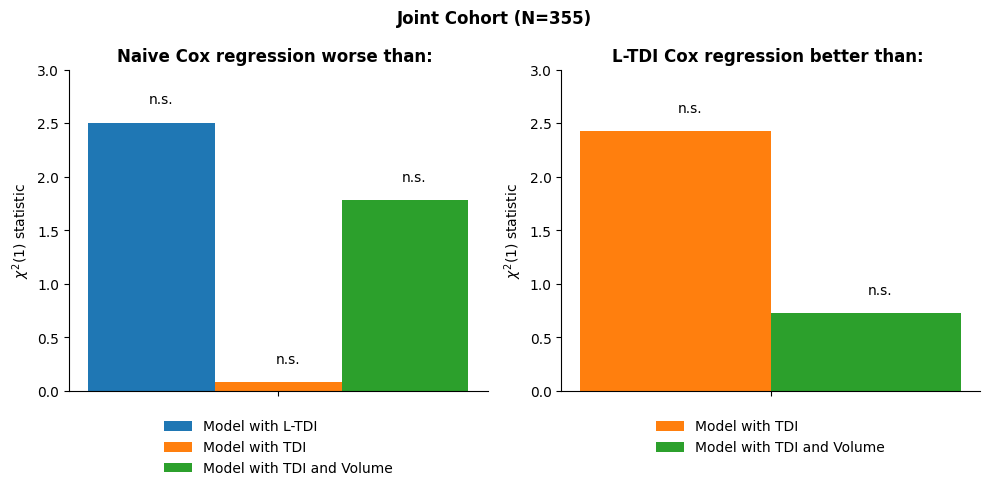

In [17]:
def get_significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"  
    elif p < 0.05:
        return "*"  
    else:
        return "n.s." 
    
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bar_width = 0.2
time_labels = [""]
x = np.arange(len(time_labels))

### Measuring the added value of tract density-based covariates
model_labels = ["Model with L-TDI", "Model with TDI", "Model with TDI and Volume"]
colors = ["tab:blue", "tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI, chi2_TDI, chi2_TDI_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[0].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[0].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,
            height + 0.15, 
            significance,
            ha="center", va="bottom", fontsize=10
        )
ax[0].set_ylim([0,3])
ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(x + bar_width, time_labels)
ax[0].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[0].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[0].set_title("Naive Cox regression worse than: ", fontweight='bold', fontsize=12)

### L-TDI against the other two models
model_labels = ["Model with TDI", "Model with TDI and Volume"]
colors = ["tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI_better, chi2_LTDI_better_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[1].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[1].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,  
            height + 0.15,  
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[1].set_ylim([0,3])
ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xticks(x + bar_width/2, time_labels)
ax[1].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[1].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[1].set_title("L-TDI Cox regression better than: ", fontweight='bold', fontsize=12)

fig.suptitle(f"Joint Cohort (N={len(data)})", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Cox-regression.{fmt}"), dpi=dpi, format=fmt)

### EOR-less models

We can follow the same procedure while excluding the extent of surgery as a covariate of interest. However, this analysis should not be viewed in isolation; rather, it is conducted to assess the impact of tract density-based markers. In this cohort, stratification based on surgical procedures, along with age, accounts for most of the predictive power. Even the MGMT promoter status shows only a limited effect on hazard, suggesting that EOR may be obscuring the added benefits of multiple covariates. At this stage, our focus is on validation, and the results clearly indicate a consistent trend of L-TDI as an informative marker.

In [18]:
## L-TDI marker
covariates = ["sex", "age", "ltdi", "mgmt"]
data = DATA[covariates+["OS","status"]].dropna()
cox_ltdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_ltdi = cox_ltdi.fit()
print(results_ltdi.summary(yname="Overall survival (days)", xname=covariates, title=f"L-TDI as covariate (LLF = {round(results_ltdi.llf,3)})"))
LLF_with_LTDI = cox_ltdi.loglike(results_ltdi.params)

## TDI marker
print()
covariates = ["sex", "age", "tdi", "mgmt"]
data = DATA[covariates+["OS","status"]].dropna()
cox_tdi = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi = cox_tdi.fit()
print(results_tdi.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI as covariate (LLF = {round(results_tdi.llf,3)})"))
LLF_with_TDI = cox_tdi.loglike(results_tdi.params)

## TDI marker and volume
print()
covariates = ["sex", "age", "tdi", "volume", "mgmt"]
data = DATA[covariates+["OS","status"]].dropna()
cox_tdi_volume = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results_tdi_volume = cox_tdi_volume.fit()
print(results_tdi_volume.summary(yname="Overall survival (days)", xname=covariates, title=f"TDI and volume as covariates (LLF = {round(results_tdi_volume.llf,3)})"))
LLF_with_TDI_volume = cox_tdi_volume.loglike(results_tdi_volume.params)

## No tract density markers
print()
covariates = ["sex", "age", "mgmt"]
data = DATA[covariates+["OS","status"]].dropna()
cox = PHReg(
    data["OS"],
    data[covariates],
    status=data["status"]
)
results = cox.fit()
print(results.summary(yname="Overall survival (days)", xname=covariates, title=f"Without tract-based covariates (LLF = {round(results.llf,3)})"))
LLF_without_tracts = cox.loglike(results.params)

            L-TDI as covariate (LLF = -1052.079)
Model:              PH Reg                  Sample size: 352
Dependent variable: Overall survival (days) Num. events: 216
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.2235    0.1436 0.7997 -1.5564 0.1196 0.6035 1.0597
age     0.0311    0.0065 1.0316  4.7665 0.0000 1.0185 1.0449
ltdi    0.1113    0.0373 1.1177  2.9839 0.0028 1.0389 1.2024
mgmt   -0.1475    0.0754 0.8629 -1.9565 0.0504 0.7444 1.0003
Confidence intervals are for the hazard ratios

             TDI as covariate (LLF = -1055.231)
Model:              PH Reg                  Sample size: 352
Dependent variable: Overall survival (days) Num. events: 216
Ties:               Breslow                                 
------------------------------------------------------------
 

In [19]:
print(f"Log-likelihood of the model with the L-TDI as a covariate: {LLF_with_LTDI}")
print(f"Log-likelihood of the model with the TDI as a covariate: {LLF_with_TDI}")
print(f"Log-likelihood of the model with the TDI and volume as covariates: {LLF_with_TDI_volume}")
print(f"Log-likelihood of the model without tract density-based markers as covariates: {LLF_without_tracts}")
print()

DF = 1 # The full model contains 1 more parameter than the reduced model
chi2_LTDI = - 2 * (LLF_without_tracts - LLF_with_LTDI)
chi2_TDI = - 2 * (LLF_without_tracts - LLF_with_TDI)
chi2_TDI_volume = - 2 * (LLF_without_tracts - LLF_with_TDI_volume)
chi2_TDI_better = - 2 * (LLF_with_LTDI - LLF_with_TDI)
chi2_LTDI_better = - 2 * (LLF_with_TDI - LLF_with_LTDI)
chi2_LTDI_better_volume = - 2 * (LLF_with_TDI_volume - LLF_with_LTDI)

p_value_LTDI = 1 - chi2.cdf(chi2_LTDI, df=DF)
p_value_TDI = 1 - chi2.cdf(chi2_TDI, df=DF)
p_value_TDI_volume = 1 - chi2.cdf(chi2_TDI_volume, df=DF)
p_value_TDI_better = 1 - chi2.cdf(chi2_TDI_better, df=DF)
p_value_LTDI_better = 1 - chi2.cdf(chi2_LTDI_better, df=DF)
p_value_LTDI_better_volume = 1 - chi2.cdf(chi2_LTDI_better_volume, df=DF)

print(f"P-value associated with the addition of the L-TDI covariate: {p_value_LTDI:.4f}")
print(f"P-value associated with the addition of the TDI covariate: {p_value_TDI:.4f}")
print(f"P-value associated with the addition of the TDI and volume covariates: {p_value_TDI_volume:.4f}")
print(f"P-value supposing that the TDI-based model performs better: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better: {p_value_LTDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the TDI and volume: {p_value_LTDI_better_volume:.4f}")

Log-likelihood of the model with the L-TDI as a covariate: -1052.07925948707
Log-likelihood of the model with the TDI as a covariate: -1055.231085671921
Log-likelihood of the model with the TDI and volume as covariates: -1054.030604859717
Log-likelihood of the model without tract density-based markers as covariates: -1056.48176851949

P-value associated with the addition of the L-TDI covariate: 0.0030
P-value associated with the addition of the TDI covariate: 0.1137
P-value associated with the addition of the TDI and volume covariates: 0.0268
P-value supposing that the TDI-based model performs better: 1.0000
P-value supposing that the LTDI-based model performs better: 0.0120
P-value supposing that the LTDI-based model performs better than the TDI and volume: 0.0482


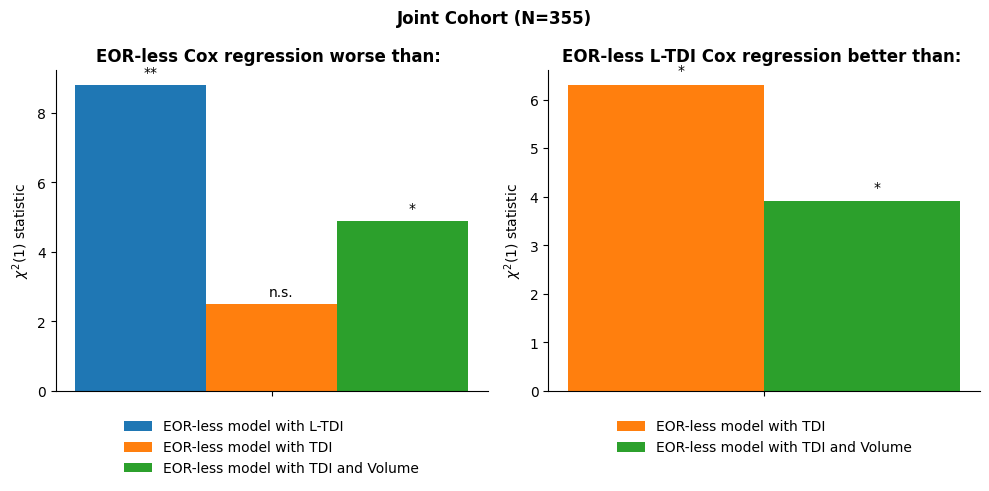

In [20]:
def get_significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"  
    elif p < 0.05:
        return "*"  
    else:
        return "n.s." 
    
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bar_width = 0.2
time_labels = [""]
x = np.arange(len(time_labels))

### Measuring the added value of tract density-based covariates
model_labels = ["EOR-less model with L-TDI", "EOR-less model with TDI", "EOR-less model with TDI and Volume"]
colors = ["tab:blue", "tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI, chi2_TDI, chi2_TDI_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[0].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[0].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,
            height + 0.15, 
            significance,
            ha="center", va="bottom", fontsize=10
        )
ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(x + bar_width, time_labels)
ax[0].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[0].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[0].set_title("EOR-less Cox regression worse than: ", fontweight='bold', fontsize=12)

### L-TDI against the other two models
model_labels = ["EOR-less model with TDI", "EOR-less model with TDI and Volume"]
colors = ["tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI_better, chi2_LTDI_better_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[1].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[1].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,  
            height + 0.15,  
            significance,
            ha="center", va="bottom", fontsize=10
        )
ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xticks(x + bar_width/2, time_labels)
ax[1].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[1].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[1].set_title("EOR-less L-TDI Cox regression better than: ", fontweight='bold', fontsize=12)

fig.suptitle(f"Joint Cohort (N={len(data)})", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Cox-regression_without-EOR.{fmt}"), dpi=dpi, format=fmt)

### To compute the C-Index (Harrell's concordance index) we use the scikit-survival package.

It is worth noting that using a second software package is useful because it increases the reliability of the analyses and robustness of the results reported!

In [21]:
n_perms = 1000

In [22]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the L-TDI as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

Cox model including the L-TDI as a covariate (N=355): 100%|██████████| 1000/1000 [00:13<00:00, 72.71it/s]

C-index = 0.6855777383797117 (p=0.0)
	sex:	Log Hazard Ratio = -0.2705 & Hazard Ratio = 0.7630
	age:	Log Hazard Ratio = 0.0349 & Hazard Ratio = 1.0355
	ltdi:	Log Hazard Ratio = 0.0590 & Hazard Ratio = 1.0608
	mgmt:	Log Hazard Ratio = -0.1271 & Hazard Ratio = 0.8806
	EOR:	Log Hazard Ratio = -0.7991 & Hazard Ratio = 0.4497


In [23]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the TDI as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

Cox model including the TDI as a covariate (N=355): 100%|██████████| 1000/1000 [00:15<00:00, 65.31it/s]

C-index = 0.6815951077879698 (p=0.0)
	sex:	Log Hazard Ratio = -0.2526 & Hazard Ratio = 0.7768
	age:	Log Hazard Ratio = 0.0356 & Hazard Ratio = 1.0362
	tdi:	Log Hazard Ratio = 0.0005 & Hazard Ratio = 1.0005
	mgmt:	Log Hazard Ratio = -0.1274 & Hazard Ratio = 0.8804
	EOR:	Log Hazard Ratio = -0.8272 & Hazard Ratio = 0.4373


In [24]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model excluding the tract density markers as covariates (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

Cox model excluding the tract density markers as covariates (N=355): 100%|██████████| 1000/1000 [00:15<00:00, 66.29it/s]

C-index = 0.6820190652380586 (p=0.0)
	sex:	Log Hazard Ratio = -0.2429 & Hazard Ratio = 0.7843
	age:	Log Hazard Ratio = 0.0358 & Hazard Ratio = 1.0364
	mgmt:	Log Hazard Ratio = -0.1255 & Hazard Ratio = 0.8820
	EOR:	Log Hazard Ratio = -0.8340 & Hazard Ratio = 0.4343


We can follow the same procedure while excluding the extent of surgery as a covariate of interest. However, this analysis should not be viewed in isolation; rather, it is conducted to assess the impact of tract density-based markers. In this cohort, stratification based on surgical procedures, along with age, accounts for most of the predictive power. Even the MGMT promoter status shows only a limited effect on hazard, suggesting that EOR may be obscuring the added benefits of multiple covariates. At this stage, our focus is on validation, and the results clearly indicate a consistent trend of L-TDI as an informative marker.

In [25]:
## L-TDI
covariates = ["sex", "age", "ltdi", "mgmt"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)
pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the L-TDI as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

## TDI
print()
covariates = ["sex", "age", "tdi", "mgmt"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)
pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the TDI as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

## No tract density markers
print()
covariates = ["sex", "age", "mgmt"]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox = CoxPHSurvivalAnalysis(n_iter=200)
cox.fit(data[covariates], OS_STATS)
c_index = cox.score(data[covariates], OS_STATS)
pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model excluding the tract density markers as covariates (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index)
print(f"C-index = {c_index} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox.coef_[i]):.4f}")

Cox model including the L-TDI as a covariate (N=355): 100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


C-index = 0.6501708676995812 (p=0.0)
	sex:	Log Hazard Ratio = -0.2235 & Hazard Ratio = 0.7997
	age:	Log Hazard Ratio = 0.0311 & Hazard Ratio = 1.0316
	ltdi:	Log Hazard Ratio = 0.1113 & Hazard Ratio = 1.1177
	mgmt:	Log Hazard Ratio = -0.1475 & Hazard Ratio = 0.8629



Cox model including the TDI as a covariate (N=355): 100%|██████████| 1000/1000 [00:14<00:00, 70.29it/s]


C-index = 0.6386340861789871 (p=0.0)
	sex:	Log Hazard Ratio = -0.2250 & Hazard Ratio = 0.7985
	age:	Log Hazard Ratio = 0.0310 & Hazard Ratio = 1.0315
	tdi:	Log Hazard Ratio = 0.0028 & Hazard Ratio = 1.0028
	mgmt:	Log Hazard Ratio = -0.1469 & Hazard Ratio = 0.8634



Cox model excluding the tract density markers as covariates (N=355): 100%|██████████| 1000/1000 [00:14<00:00, 70.72it/s]

C-index = 0.6387240165471878 (p=0.0)
	sex:	Log Hazard Ratio = -0.1785 & Hazard Ratio = 0.8365
	age:	Log Hazard Ratio = 0.0321 & Hazard Ratio = 1.0327
	mgmt:	Log Hazard Ratio = -0.1417 & Hazard Ratio = 0.8679


### Feature selection

Cox feature selection for the covariate sex: 100%|██████████| 1000/1000 [00:16<00:00, 62.17it/s]


Feature: sex with a c-index of 0.5245824935214511 (p=0.2)


Cox feature selection for the covariate age: 100%|██████████| 1000/1000 [00:15<00:00, 64.91it/s]


Feature: age with a c-index of 0.6342979172665323 (p=0.0)


Cox feature selection for the covariate ltdi: 100%|██████████| 1000/1000 [00:16<00:00, 62.30it/s]


Feature: ltdi with a c-index of 0.5828534408292543 (p=0.0)


Cox feature selection for the covariate tdi: 100%|██████████| 1000/1000 [00:16<00:00, 59.55it/s]


Feature: tdi with a c-index of 0.5312649966407524 (p=0.15)


Cox feature selection for the covariate volume: 100%|██████████| 1000/1000 [00:16<00:00, 61.95it/s]


Feature: volume with a c-index of 0.5537839523946636 (p=0.017)


Cox feature selection for the covariate mgmt: 100%|██████████| 1000/1000 [00:15<00:00, 65.08it/s]


Feature: mgmt with a c-index of 0.5243068938050823 (p=0.17)


Cox feature selection for the covariate EOR: 100%|██████████| 1000/1000 [00:16<00:00, 60.60it/s]


Feature: EOR with a c-index of 0.6057683078990306 (p=0.0)


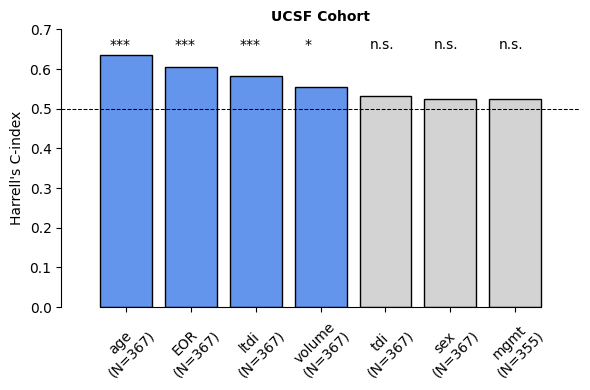

In [26]:
covariates = ["sex", "age", "ltdi", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["OS","status"]]

fig, ax = plt.subplots(1,1, figsize=(6,4))
level_CI = 95
HarrellCindex = np.zeros((len(covariates),))
HarrellCindex_p = np.zeros((len(covariates),))
colors = []
samples = []
for i in range(0,len(covariates)):
    data_notna = data[[covariates[i],"OS","status"]].dropna()
    samples.append(len(data_notna))

    OS_STATS = np.array(
        [(st, ovs) for st, ovs in zip(data_notna["status"].values==1, data_notna["OS"].values)],
        dtype=[('event', 'bool'),('time', 'float')]
    )
    Cmodel = CoxPHSurvivalAnalysis(n_iter=200)
    Cmodel.fit(data_notna[covariates[i]].values.reshape(-1, 1),OS_STATS)
    HarrellCindex[i] = Cmodel.score(data_notna[covariates[i]].values.reshape(-1, 1),OS_STATS)

    # Permutation test for the model without site effect
    pop = []
    for _ in tqdm(range(n_perms), desc=f"Cox feature selection for the covariate {covariates[i]}"):
        perm_OS_STATS = np.random.permutation(OS_STATS)
        p_Cmodel = CoxPHSurvivalAnalysis()
        p_Cmodel.fit(data_notna[covariates[i]].values.reshape(-1, 1),perm_OS_STATS)
        pop.append(p_Cmodel.score(data_notna[covariates[i]].values.reshape(-1, 1),perm_OS_STATS))
    HarrellCindex_p[i] = np.mean(np.array(pop) >= HarrellCindex[i])
    if HarrellCindex_p[i]<=0.001:
        colors.append("cornflowerblue")
    elif HarrellCindex_p[i]<=0.01:
        colors.append("cornflowerblue")
    elif HarrellCindex_p[i]<=0.05:
        colors.append("cornflowerblue")
    else:            
        colors.append("lightgray")
    # Summary
    print(f"Feature: {covariates[i]} with a c-index of {HarrellCindex[i]} (p={HarrellCindex_p[i]})")
ax.bar(
    range(0,len(covariates)), 
    np.sort(HarrellCindex)[::-1],
    edgecolor="black",
    color=[colors[ii] for ii in np.argsort(HarrellCindex)[::-1]]
)
for ii, pval in enumerate(HarrellCindex_p[np.argsort(HarrellCindex)[::-1]]):
    if pval<=0.001:
        ax.text(ii-.25, .65, '***', color='black',fontsize=10, transform=ax.transData)
    elif pval<=0.01:
        ax.text(ii-.25, .65, '**', color='black',fontsize=10, transform=ax.transData)
    elif pval<=0.05:
        ax.text(ii-.25, .65, '*', color='black',fontsize=10, transform=ax.transData)
    else:            
        ax.text(ii-.25, .65, 'n.s.', color='black',fontsize=10, transform=ax.transData)
ax.hlines(0.5, -1, len(covariates), color='black', linewidth=.75, linestyle='--')
ax.spines[["top","right"]].set_visible(False)
ax.set_ylabel("Harrell's C-index")
ax.set_ylim([0,0.7])
ax.set_xlim([-1,len(covariates)])
ax.set_xticks(range(0,len(covariates)))
ax.set_xticklabels([f"{covariates[ii]}\n(N={samples[ii]})" for ii in np.argsort(HarrellCindex)[::-1]], rotation=45)
ax.spines['bottom'].set_bounds(-.4,len(covariates)-.6)
ax.spines['left'].set_bounds(0,.7)
ax.set_title("UCSF Cohort", fontsize=10, fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Feature-importance.{fmt}"), dpi=dpi, format=fmt)

### Feature importance

Select K features workflow: 100%|██████████| 50/50 [34:16<00:00, 41.13s/it]


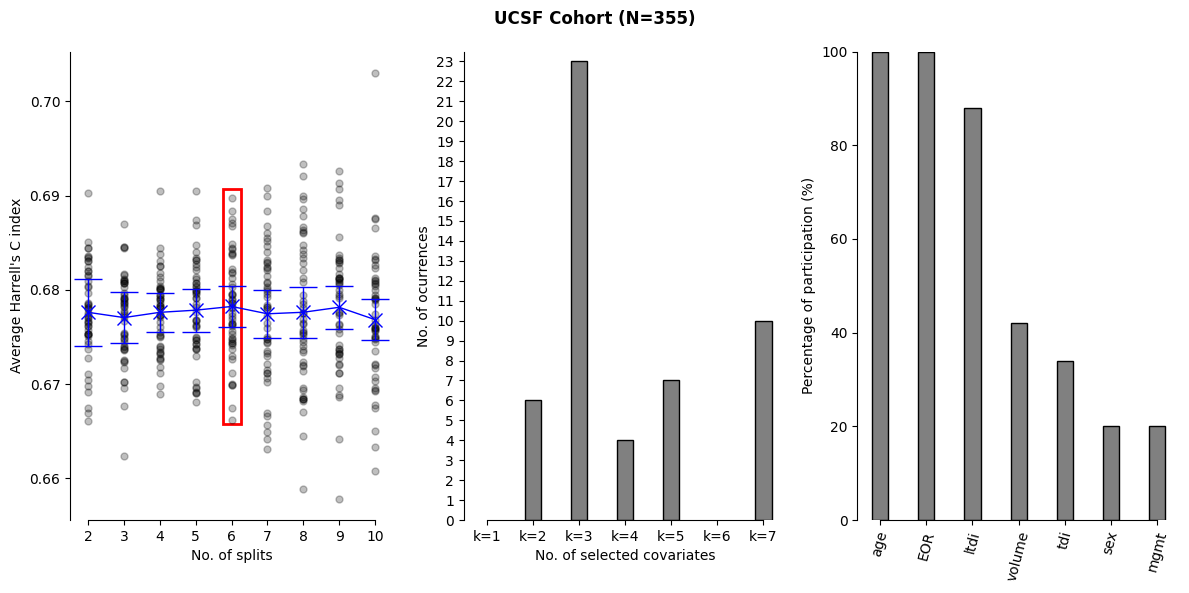

In [27]:
def Harrell_C_index(X, y):
    n_features = X.shape[1]
    Cscores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        Cscores[j] = m.score(Xj, y)
    return Cscores

pipe = Pipeline(
    [
        ("select", SelectKBest(Harrell_C_index)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)
splits = range(2,11) # 10
runs = 50 # 50

# Features to consider in the order determined by their respective importances (execute cell above)
covariates = ["sex", "age", "ltdi", "tdi", "volume", "mgmt", "EOR"]
covariates = [covariates[ii] for ii in np.argsort(HarrellCindex)[::-1]]
data = DATA[covariates+["OS","status"]].dropna()
OS_STATS = np.array([(st, oss) for st,oss in zip(data["status"],data["OS"])], dtype=[('event', 'bool'),('time', '<f4')])
features = data[covariates]

# Feature selection workflow
param_grid = {"select__k": np.arange(1, len(covariates)+1)}
mean_test = np.zeros((runs, len(splits)))
k_best_results = np.zeros((runs, len(splits)))
fig, ax = plt.subplots(1,3, figsize=(12,6))
for tt in tqdm(range(runs), desc=f"Select K features workflow"):
    for i, spl in enumerate(splits):
        cv = KFold(n_splits=spl, shuffle=True, random_state=None) # Assign a given random state if you want to ensure reproducibility
        gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
        gcv.fit(features, OS_STATS)        
        results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
        mean_test[tt,i] = results["mean_test_score"].values.max()
        k_best_results[tt,i] = results["param_select__k"].values[0]
        ax[0].plot(spl, mean_test[tt,i], 'o', color='black', alpha=0.25, markersize=5)


best_split = splits[mean_test.mean(axis=0).argmax()]-2
k_feat, feature_counts = np.unique(k_best_results[:,best_split], return_counts=True)
ax[0].errorbar(splits, mean_test.mean(axis=0), yerr=mean_test.std(axis=0)/np.sqrt(splits), linestyle='-', color='blue', linewidth=1, fmt='x',markersize=10, capsize=10)
rect = patches.Rectangle((best_split+1.75, mean_test.mean(axis=0).max()-.0125), 0.5, 0.025, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(splits)
ax[0].set_xticklabels(splits)
ax[0].set_xlim([splits[0]-.5, splits[-1]+.5])
ax[0].set_xlabel("No. of splits")
ax[0].set_ylabel("Average Harrell's C index")
ax[0].spines['bottom'].set_bounds(splits[0], splits[-1])
ax[1].bar(
    k_feat, 
    feature_counts,
    edgecolor="black",
    color="gray",
    width=.35
)
ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xlim([.5,features.shape[-1]+.5])
ax[1].set_xticks(range(1,features.shape[-1]+1))
ax[1].set_xticklabels([f"k={ii}" for ii in range(1,features.shape[-1]+1)])
ax[1].set_ylabel("No. of ocurrences")
ax[1].set_xlabel("No. of selected covariates")
ax[1].spines['bottom'].set_bounds(1,features.shape[-1])
ax[1].set_ylim([0, max(feature_counts)+.5])
ax[1].set_yticks(range(0,max(feature_counts)+1))
ax[1].set_yticklabels(range(0,max(feature_counts)+1))
feature_participation = np.zeros((len(covariates),)) # Same order as in labels
for i in range(len(k_feat)):
    k_fs = int(k_feat[i])
    for j in range(k_fs):
        feature_participation[j] += feature_counts[i]

ax[2].bar(
    range(1,features.shape[-1]+1), 
    100*feature_participation/runs,
    edgecolor="black",
    color="gray",
    width=.35
)
ax[2].spines[["top","right"]].set_visible(False)
ax[2].set_xlim([.5,features.shape[-1]+.5])
ax[2].set_xticks(range(1,features.shape[-1]+1))
ax[2].set_xticklabels(covariates, rotation=75)
ax[2].set_ylabel("Percentage of participation (%)")
ax[2].spines['bottom'].set_bounds(1,features.shape[-1])
ax[2].set_ylim([0, 100])
ax[2].set_yticks([0,20,40,60,80,100])
ax[2].set_yticklabels([0,20,40,60,80,100])

fig.suptitle(f"UCSF Cohort (N={len(data)})", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Feature-selection.{fmt}"), dpi=dpi, format=fmt)

## Missing value strategy &\to& ??

# Logistic regressions

## Death at 6 months

### Including the L-TDI covariate

In [28]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.376359
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  322
Model:                          Logit   Df Residuals:                      316
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1938
Time:                        17:14:49   Log-Likelihood:                -121.19
converged:                       True   LL-Null:                       -150.32
Covariance Type:            nonrobust   LLR p-value:                 2.765e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6943      1.303     -3.603      0.000      -7.248      -2.141
sex           -0.8517      0.

### Including the TDI covariate

In [29]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.385035
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  322
Model:                          Logit   Df Residuals:                      316
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1752
Time:                        17:14:49   Log-Likelihood:                -123.98
converged:                       True   LL-Null:                       -150.32
Covariance Type:            nonrobust   LLR p-value:                 3.905e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6383      1.299     -2.801      0.005      -6.184      -1.092
sex           -0.7724      0.

### Including the TDI and volume as covariates

In [30]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.375363
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  322
Model:                          Logit   Df Residuals:                      315
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1960
Time:                        17:14:49   Log-Likelihood:                -120.87
converged:                       True   LL-Null:                       -150.32
Covariance Type:            nonrobust   LLR p-value:                 7.482e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3492      1.378     -3.156      0.002      -7.051      -1.648
sex           -0.7623      0.

### Excluding tract density-based covariates

In [31]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.385195
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  322
Model:                          Logit   Df Residuals:                      317
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1749
Time:                        17:14:49   Log-Likelihood:                -124.03
converged:                       True   LL-Null:                       -150.32
Covariance Type:            nonrobust   LLR p-value:                 1.043e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7732      1.227     -3.076      0.002      -6.178      -1.369
sex           -0.7909      0.

## Death at 12 months

### Including the L-TDI covariate

In [32]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.545937
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  284
Model:                          Logit   Df Residuals:                      278
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1801
Time:                        17:14:49   Log-Likelihood:                -155.05
converged:                       True   LL-Null:                       -189.11
Covariance Type:            nonrobust   LLR p-value:                 2.502e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0003      1.026     -1.950      0.051      -4.011       0.010
sex           -0.4449      0.

### Including the TDI covariate

In [33]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.555310
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  284
Model:                          Logit   Df Residuals:                      278
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1661
Time:                        17:14:49   Log-Likelihood:                -157.71
converged:                       True   LL-Null:                       -189.11
Covariance Type:            nonrobust   LLR p-value:                 3.183e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1035      1.038     -1.063      0.288      -3.138       0.931
sex           -0.4402      0.

### Including the TDI and volume covariates

In [34]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.544345
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  284
Model:                          Logit   Df Residuals:                      277
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1825
Time:                        17:14:49   Log-Likelihood:                -154.59
converged:                       True   LL-Null:                       -189.11
Covariance Type:            nonrobust   LLR p-value:                 6.432e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6546      1.077     -1.537      0.124      -3.765       0.456
sex           -0.4135      0.

### Excluding tract density-based covariates

In [35]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.555422
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  284
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1659
Time:                        17:14:49   Log-Likelihood:                -157.74
converged:                       True   LL-Null:                       -189.11
Covariance Type:            nonrobust   LLR p-value:                 7.664e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2035      0.959     -1.255      0.210      -3.084       0.677
sex           -0.4456      0.

### Death at 18 months

### Including the L-TDI covariate

In [36]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.565871
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  264
Model:                          Logit   Df Residuals:                      258
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1668
Time:                        17:14:49   Log-Likelihood:                -149.39
converged:                       True   LL-Null:                       -179.31
Covariance Type:            nonrobust   LLR p-value:                 1.315e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6994      1.061      0.659      0.510      -1.380       2.779
sex           -0.3162      0.

### Including the TDI covariate

In [37]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.568146
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  264
Model:                          Logit   Df Residuals:                      258
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1635
Time:                        17:14:49   Log-Likelihood:                -149.99
converged:                       True   LL-Null:                       -179.31
Covariance Type:            nonrobust   LLR p-value:                 2.328e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3645      1.098      1.243      0.214      -0.787       3.516
sex           -0.3163      0.

### Including the TDI and volume covariates

In [38]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.566216
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  264
Model:                          Logit   Df Residuals:                      257
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1663
Time:                        17:14:49   Log-Likelihood:                -149.48
converged:                       True   LL-Null:                       -179.31
Covariance Type:            nonrobust   LLR p-value:                 5.296e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1705      1.109      1.056      0.291      -1.003       3.344
sex           -0.2966      0.

### Excluding tract density-based covariates

In [39]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["OS", "status"]].dropna()

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.568768
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  264
Model:                          Logit   Df Residuals:                      259
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1626
Time:                        17:14:49   Log-Likelihood:                -150.15
converged:                       True   LL-Null:                       -179.31
Covariance Type:            nonrobust   LLR p-value:                 6.586e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1222      1.010      1.111      0.267      -0.858       3.102
sex           -0.3270      0.

### Comparisson through Log-likelihood ratios

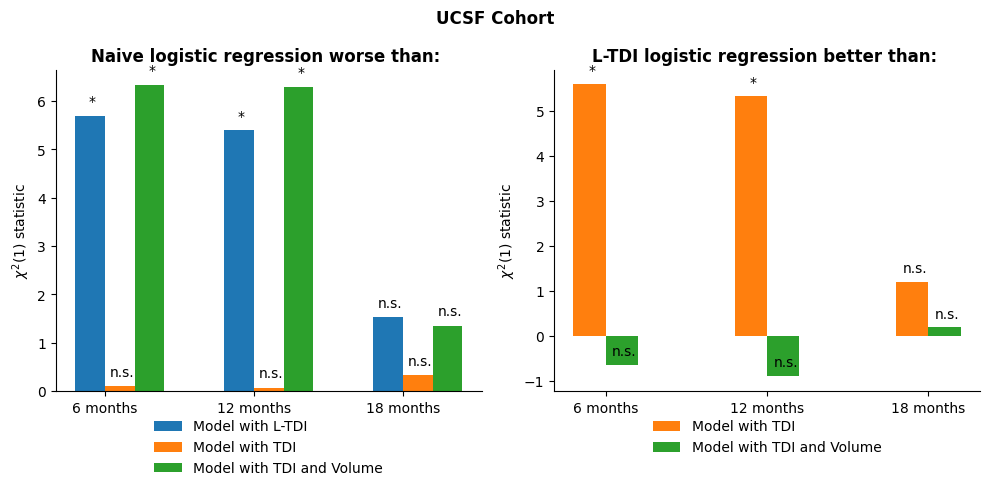

In [40]:
def get_significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"  
    elif p < 0.05:
        return "*"  
    else:
        return "n.s." 
    
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bar_width = 0.2
time_labels = ["6 months", "12 months", "18 months"]
x = np.arange(len(time_labels))

### Measuring the added value of tract density-based covariates
model_labels = ["Model with L-TDI", "Model with TDI", "Model with TDI and Volume"]
colors = ["tab:blue", "tab:orange", "tab:green"]
llrs = -2*np.array([
    [LR_LTDI_6-LR_without_6, LR_TDI_6-LR_without_6, LR_TDI_volume_6-LR_without_6],
    [LR_LTDI_12-LR_without_12, LR_TDI_12-LR_without_12, LR_TDI_volume_12-LR_without_12],
    [LR_LTDI_18-LR_without_18, LR_TDI_18-LR_without_18, LR_TDI_volume_18-LR_without_18]
])
llrs = - llrs ## We want to see the increase in LR when adding covariates!!
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[0].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[0].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,
            height + 0.15, 
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(x + bar_width/2, time_labels)
ax[0].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[0].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[0].set_title("Naive logistic regression worse than: ", fontweight='bold', fontsize=12)

### L-TDI against the other two models
model_labels = ["Model with TDI", "Model with TDI and Volume"]
colors = ["tab:orange", "tab:green"]
llrs = -2*np.array([
    [LR_TDI_6-LR_LTDI_6, LR_TDI_volume_6-LR_LTDI_6],
    [LR_TDI_12-LR_LTDI_12, LR_TDI_volume_12-LR_LTDI_12],
    [LR_TDI_18-LR_LTDI_18, LR_TDI_volume_18-LR_LTDI_18]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[1].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[1].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,  
            height + 0.15,  
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xticks(x + bar_width/2, time_labels)
ax[1].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[1].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[1].set_title("L-TDI logistic regression better than: ", fontweight='bold', fontsize=12)

fig.suptitle(f"UCSF Cohort", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Logistic-regression.{fmt}"), dpi=dpi, format=fmt)